In [ ]:
!mkdir my_challenge_project
!cd my_challenge_project
!git clone https://github.com/myelin-foundry/challenge.git

### External Files
1. Tensorflow (GPU) - https://www.tensorflow.org/install (1.12 with CUDA 9.2)
2. SciPy - https://pypi.org/project/scipy/
3. NumPy - https://pypi.org/project/numpy/
4. Pillow - https://pypi.org/project/Pillow/
5. Matplotlib - https://pypi.org/project/matplotlib/

### Download VGG-19 Weights

In [ ]:
!curl -O http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat

In [43]:
import os
import sys

import urllib
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf 

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL
from PIL import Image
#import Image
from IPython.display import display, Image

%matplotlib inline

Definition of Hyperparameters:

The style layers selected are used in order to compute

We can construct images whose feature maps at a chosen convolution layer match the corresponding feature maps of a given content image.

In [55]:
style_layer = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"] #Selected Convolution Layers for Style


style_image = "picasso_selfportrait.jpg" #Path to Style Image
content_image = "japanese_garden.jpg" #Path to Content Image

# Image Shape : (image_height, image_width, num_channels)

image_width = 800
image_height = 600
num_channels = 3

"""
Beta --- Style Weight
Alpha --- Content Weight
lr --- Learning Rate

"""
beta = 5
alpha = 200
lr = 1e-4

mean_values= np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

#Loading the weights of the VGG Model

VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'


### Preprocessing Image

Both the content and style image are pre-processed and reshaped to desired dimensions before they are used for Style Transfer and the function for reconstructing the output image is also specified.

In [56]:
def preprocess_image(path):
    image = scipy.misc.imread(path)
    image=scipy.misc.imresize(image, (image_height, image_width, num_channels))
    image = np.reshape(image, ((1,) + image.shape))
    image = image - mean_values
    return image

def output(path, image):
    image = image + mean_values
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

###  Model Definition

In the following function, we load the VGG-19 model, it is currently the most effective pre-trained model which can be used for style transfer, as other models such as ResNet, Inception are not as effective for the task of neural style transfer.

In [57]:
def model():
    vgg = scipy.io.loadmat(VGG_MODEL)
    layers = vgg["layers"]
  
    def weight(l):
        weights = layers[0][l][0][0][2][0][0] #Load the Weights from the mat file
        bias = layers[0][l][0][0][2][0][1] #Load Bias values from the mat file
        return weights, bias
    
    def conv_layer(prev_layer, l): #Conv layer defintion
        weight_val = weight(l)[0]
        bias_val = weight(l)[1]
    
        w = tf.constant(weight_val)
        b = tf.constant(np.reshape(bias_val, (bias_val.size)))
    
        conv2d = tf.nn.conv2d(prev_layer, filter=w, strides=[1, 1, 1, 1], padding="SAME") + b
    
        return tf.nn.relu(conv2d)
  
    def average_pooling(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides = [1, 2, 2, 1], padding="SAME")
  
    graph = {}
  
    graph["input"] = tf.Variable(np.zeros((1, image_height, image_width, num_channels)), dtype="float32")
  
    #First Set of Convolutional Layers
  
    graph["conv1_1"] = conv_layer(graph["input"], 0)
    graph["conv1_2"] = conv_layer(graph["conv1_1"], 2)
    #Average Pooling
    graph["avgpool1"] = average_pooling(graph["conv1_2"])
  
    #Second Set of Convolutional Layers
    graph["conv2_1"] = conv_layer(graph["avgpool1"], 5)
    graph["conv2_2"] = conv_layer(graph["conv2_1"], 7)
    graph["avgpool2"] = average_pooling(graph["conv2_2"])
  
    #Third Set of Convolutional Layers
    graph["conv3_1"] = conv_layer(graph["avgpool2"], 10)
    graph["conv3_2"] = conv_layer(graph["conv3_1"], 12)
    graph["conv3_3"] = conv_layer(graph["conv3_2"], 14)
    graph["conv3_4"] = conv_layer(graph["conv3_3"], 16)
    graph["avgpool3"] = average_pooling(graph["conv3_4"])
  
    #Fourth set of Convolutional Layers
    graph["conv4_1"] = conv_layer(graph["avgpool3"], 19)
    graph["conv4_2"] = conv_layer(graph["conv4_1"], 21)
    graph["conv4_3"] = conv_layer(graph["conv4_2"], 23)
    graph["conv4_4"] = conv_layer(graph["conv4_3"], 25)
    graph["avgpool4"] = average_pooling(graph["conv4_4"])
  
    #Fifth Set of Convolutional Layers
    graph["conv5_1"] = conv_layer(graph["avgpool4"], 28)
    graph["conv5_2"] = conv_layer(graph["conv5_1"], 30)
    graph["conv5_3"] = conv_layer(graph["conv5_2"], 32)
    graph["conv5_4"] = conv_layer(graph["conv5_3"], 34)
    graph['avgpool5'] = average_pooling(graph['conv5_4'])
    
    return graph

#### Generating Noisy Image

In [51]:
def generate_noise_image(content_image,):
    noise_image = np.random.uniform(-20, 20,(1, image_height,image_width,num_channels)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * 0.4 + content_image * 0.6#probability
    return input_image

## Defining the loss parameters

### Content Loss
Given a chosen content layer l, the content loss is defined as the Mean Squared Error between the feature map F of our content image C and the feature map P of our generated image Y.

<img src = "https://cdn-images-1.medium.com/max/800/1*1YfGhmzBw7EK3e8CRpZbuA.png" >


### Gram Matrix
If the feature map is a matrix F, then each entry in the Gram matrix G can be given by:
<img src = "https://cdn-images-1.medium.com/max/800/1*5xx9KmhVb59Mxe_buOwHBA.png" >



### Style Loss
The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.
<img src = "https://cdn-images-1.medium.com/max/800/1*PuYveCM2BlgFfjUCr6I_Ng.png" >

In [58]:
def content_loss(current_feature, content_feature):
    m = current_feature.shape[1] * current_feature.shape[2]
    n = current_feature.shape[3]
    return (1 / (2 * m * n)) * tf.reduce_sum(tf.pow(content_feature - current_feature, 2))

def gram_matrix(channels, img_size, img):
    img = tf.reshape(img, (img_size, channels))
    return tf.matmul(tf.transpose(img), img)

def style_loss_single(style_image, generated_image):
    m = style_image.shape[1] * style_image.shape[2]
    n = style_image.shape[3]
    A = gram_matrix(n, m, style_image)
    G = gram_matrix(n, m, generated_image)
  
    return (1 / (4 * n**2 * m**2) * tf.reduce_sum(tf.pow(A - G, 2)))

def total_style_loss():
    total = 0
  
    weight = [0.2, 0.2, 0.2, 0.2, 0.2]
  
    for i in range(0,len(style_layer)):
        total += weight[i] * style_loss_single(sess.run(graph[style_layer[i]]), graph[style_layer[i]])
    return total
    

In [53]:
content_image = preprocess_image(content_image)
style = preprocess_image(style_image)

/home/samantha/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/samantha/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


## Total Loss is given by :

The total loss can then be written as a weighted sum of the both the style and content losses.


<img src = "https://cdn-images-1.medium.com/max/800/1*vLt5-hC5X8MvOD1wPhyEjQ.png" >

We will minimize our total loss by Adam optimizer. As our loss go down we will go close to our goal of producing a style transfer image Y.
<img src = "https://cdn-images-1.medium.com/max/800/1*r2T1RTjGMyCvYwY3EIOp1Q.gif" >

(1, 600, 800, 3)
(1, 600, 800, 3)
ruby
Iteration: 0 | Total Loss: 30691518464.0 | Style Loss: 153457376.0 | Content Loss: 8773.4873046875
Iteration: 100 | Total Loss: 546578304.0 | Style Loss: 2731929.75 | Content Loss: 38475.92578125
Iteration: 200 | Total Loss: 224165808.0 | Style Loss: 1119816.5 | Content Loss: 40502.62109375
Iteration: 300 | Total Loss: 126945944.0 | Style Loss: 633690.625 | Content Loss: 41563.68359375
Iteration: 400 | Total Loss: 81882088.0 | Style Loss: 408354.03125 | Content Loss: 42256.2265625
Iteration: 500 | Total Loss: 57688876.0 | Style Loss: 287374.78125 | Content Loss: 42784.06640625
Iteration: 600 | Total Loss: 43309908.0 | Style Loss: 215469.203125 | Content Loss: 43213.6015625
Iteration: 700 | Total Loss: 34018080.0 | Style Loss: 169001.1875 | Content Loss: 43569.18359375
Iteration: 800 | Total Loss: 32009196.0 | Style Loss: 158952.625 | Content Loss: 43734.234375
Iteration: 900 | Total Loss: 24129360.0 | Style Loss: 119545.6328125 | Content Loss: 440

/home/samantha/anaconda3/envs/tensorflow_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


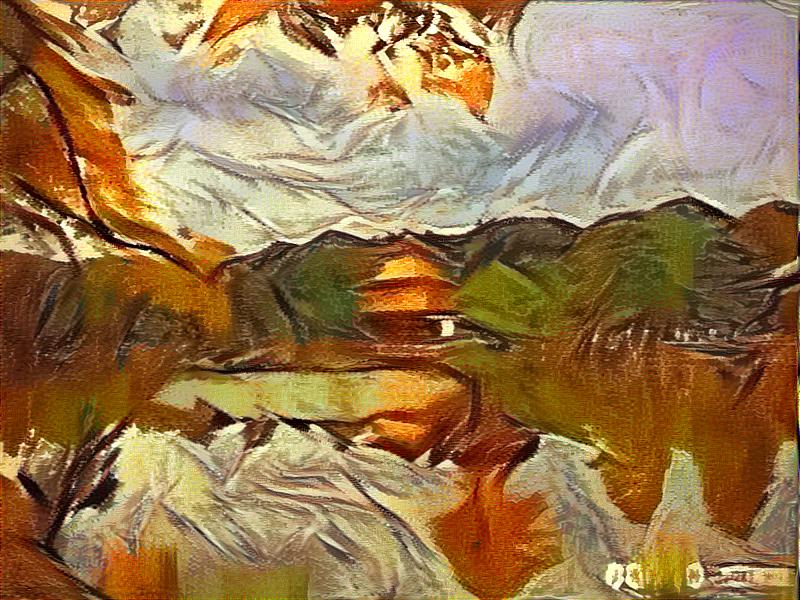

In [54]:
#Building the Model
#Starting an Interactive Session in Tensorflow
sess = tf.InteractiveSession()

print(content_image.shape)
print(style.shape)

graph = model() #Initializing the tensorflow model

input_image = generate_noise_image(content_image)

sess.run(tf.global_variables_initializer())

sess.run(graph["input"].assign(content_image))
c_loss = content_loss(sess.run(graph['conv4_2']), graph['conv4_2']) #Definition of Content loss
#print(c_loss.eval())


sess.run(graph["input"].assign(style)) 
s_loss =total_style_loss()
#print(s_loss.eval())

total_loss = beta*c_loss + alpha * s_loss

#We are using the Adam Optimizer for the 
optimizer = tf.train.AdamOptimizer(2.0, 0.9, 0.999, 1e-8)

train_step = optimizer.minimize(total_loss)

sess.run(tf.global_variables_initializer())

sess.run(graph["input"].assign(input_image))
iters = 1000

for i in range(iters):
    sess.run(train_step)
    if i%100 == 0:
        style_transferred_image = sess.run(graph['input'])
        print('Iteration: {} | Total Loss: {} | Style Loss: {} | Content Loss: {}'.format(i, sess.run(total_loss), sess.run(s_loss), sess.run(c_loss)))
style_transferred_image = sess.run(graph["input"])
output_dir = "./output"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
filename = "style_transferred_image.jpg"

output(filename, style_transferred_image)


def out():
    print("Style Transfer Complete!")
    return "./style_transferred_image.jpg"

out()



display(Image("./style_transferred_image.jpg"))